In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from tqdm.notebook import tqdm
import pickle
import random
from scipy.integrate import cumulative_trapezoid as cumtrapz

from time_vary_norm_utils import (
    up_or_down_RTs_fit_fn, cum_pro_and_reactive_time_vary_fn,
    rho_A_t_VEC_fn, up_or_down_RTs_fit_wrt_stim_fn)
from types import SimpleNamespace
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_fn

In [12]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [13]:
# LED off rows
df_led_off = df[ df['LED_trial'] == 0 ]
print(f'len df_led_off = {len(df_led_off)}')

# > 0 and < 1s valid rt 
df_led_off_valid = df_led_off[
    (df_led_off['timed_fix'] - df_led_off['intended_fix'] > 0) &
    (df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1)
]

df_led_off_valid = df_led_off_valid[df_led_off_valid['response_poke'].isin([2,3])]

print(len(df_led_off_valid))

len df_led_off = 66226
52799


In [14]:
V_A = 1.596
theta_A = 2.531
t_A_aff = -0.226
del_go = 0.13

In [15]:
# phi params
bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

K_max = 10

# vbmc

In [16]:
is_norm = True
is_time_vary = False

## loglike fn

In [17]:
def compute_loglike(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, rate_norm_l):
    
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']
    
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = 2*row['response_poke'] - 5

    rt = timed_fix
    t_stim = intended_fix

    phi_params_obj = np.nan
    
    trunc_factor_p_joint = cum_pro_and_reactive_time_vary_fn(
                            t_stim + 1,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) \
                            - \
                            cum_pro_and_reactive_time_vary_fn(
                            t_stim,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) + 1e-10
    P_joint_rt_choice = up_or_down_RTs_fit_fn(
                    rt, choice,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max)

    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    return np.log(P_joint_rt_choice_trunc)
    
    


def vbmc_loglike_fn(params):
    rate_lambda, T_0, theta_E, w, t_E_aff, rate_norm_l = params
    Z_E = (w - 0.5) * 2 * theta_E
    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, rate_norm_l)\
                                       for _, row in df_led_off_valid.iterrows() )
    return np.sum(all_loglike)


## priors

In [18]:
rate_lambda_bounds = [0.5, 4]
T_0_bounds = [100e-3, 400e-3]
theta_E_bounds = [0.1, 8]
w_bounds = [0.3, 0.7]
t_E_aff_bounds = [0.001, 0.1]
rate_norm_l_bounds = [0, 1]


rate_lambda_plausible_bounds = [1, 3]
T_0_plausible_bounds = [110e-3, 200e-3]
theta_E_plausible_bounds = [0.5, 5]
w_plausible_bounds = [0.45, 0.55]
t_E_aff_plausible_bounds = [0.01, 0.05]
rate_norm_l_plausible_bounds = [0.5, 0.99]

In [19]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    rate_lambda, T_0, theta_E, w, t_E_aff, rate_norm_l = params

    rate_lambda_logpdf = trapezoidal_logpdf(
        rate_lambda,
        rate_lambda_bounds[0],
        rate_lambda_plausible_bounds[0],
        rate_lambda_plausible_bounds[1],
        rate_lambda_bounds[1]
    )
    
    T_0_logpdf = trapezoidal_logpdf(
        T_0,
        T_0_bounds[0],
        T_0_plausible_bounds[0],
        T_0_plausible_bounds[1],
        T_0_bounds[1]
    )
    
    theta_E_logpdf = trapezoidal_logpdf(
        theta_E,
        theta_E_bounds[0],
        theta_E_plausible_bounds[0],
        theta_E_plausible_bounds[1],
        theta_E_bounds[1]
    )
    
    w_logpdf = trapezoidal_logpdf(
        w,
        w_bounds[0],
        w_plausible_bounds[0],
        w_plausible_bounds[1],
        w_bounds[1]
    )
    
    t_E_aff_logpdf = trapezoidal_logpdf(
        t_E_aff,
        t_E_aff_bounds[0],
        t_E_aff_plausible_bounds[0],
        t_E_aff_plausible_bounds[1],
        t_E_aff_bounds[1]
    )

    rate_norm_l_logpdf = trapezoidal_logpdf(
        rate_norm_l,
        rate_norm_l_bounds[0],
        rate_norm_l_plausible_bounds[0],
        rate_norm_l_plausible_bounds[1],
        rate_norm_l_bounds[1]
    )


    return (
        rate_lambda_logpdf +
        T_0_logpdf +
        theta_E_logpdf +
        w_logpdf +
        t_E_aff_logpdf +
        rate_norm_l_logpdf
    )


## prior + loglike

In [20]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# run vbmc

In [21]:
# Add bounds for all parameters
lb = np.array([
    rate_lambda_bounds[0],
    T_0_bounds[0],
    theta_E_bounds[0],
    w_bounds[0],
    t_E_aff_bounds[0],
    rate_norm_l_bounds[0]
])

ub = np.array([
    rate_lambda_bounds[1],
    T_0_bounds[1],
    theta_E_bounds[1],
    w_bounds[1],
    t_E_aff_bounds[1],
    rate_norm_l_bounds[1]
])

plb = np.array([
    rate_lambda_plausible_bounds[0],
    T_0_plausible_bounds[0],
    theta_E_plausible_bounds[0],
    w_plausible_bounds[0],
    t_E_aff_plausible_bounds[0],
    rate_norm_l_plausible_bounds[0]
])

pub = np.array([
    rate_lambda_plausible_bounds[1],
    T_0_plausible_bounds[1],
    theta_E_plausible_bounds[1],
    w_plausible_bounds[1],
    t_E_aff_plausible_bounds[1],
    rate_norm_l_plausible_bounds[1]
])

# Initialize with random values within plausible bounds
np.random.seed(42)
rate_lambda_0 = np.random.uniform(*rate_lambda_plausible_bounds)
T_0_0 = np.random.uniform(*T_0_plausible_bounds)
theta_E_0 = np.random.uniform(*theta_E_plausible_bounds)
w_0 = np.random.uniform(*w_plausible_bounds)
t_E_aff_0 = np.random.uniform(*t_E_aff_plausible_bounds)
rate_norm_l_0 = np.random.uniform(*rate_norm_l_plausible_bounds)

x_0 = np.array([
    rate_lambda_0,
    T_0_0,
    theta_E_0,
    w_0,
    t_E_aff_0,
    rate_norm_l_0
])

# Run VBMC
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      -83696.29    173840.09 92941041842233156829184.00        2        inf     start warm-up
     1         15       71718.50     81495.89    122941.31        2        inf     
     2         20       28527.44     24719.03     45159.52        2   8.41e+05     
     3         25      108483.01     51414.07   2983091.22        2    4.1e+07     
     4         30       29375.68     14048.86     86390.87        2   1.49e+06     
     5         35       44969.08     28560.17    796606.14        2    1.1e+07     
     6         40       20995.90     11551.10    223612.72        2   3.16e+06     
     7         45       47172.

/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 4. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 0. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 1. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 2. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    43        225       38083.47     21767.24      3260.53        3   1.35e+05     


/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 3. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    44        230       35276.42     16973.20      1703.77        3   8.91e+04     
    45        235       37989.85     22796.25       330.18        3   8.95e+04     
    46        240       33874.14     17734.11       894.09        3    8.5e+04     
    47        245       34627.59     19145.19      1088.32        3   8.11e+04     
    48        250       32434.61     12890.25      1362.24        3   6.88e+04     
    49        255       33573.73     15276.48       517.91        4   6.18e+04     
    50        260       34732.73     14632.75       168.13        4   5.49e+04     switch to GP opt


/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/pyvbmc/acquisition_functions/acq_fcn_log.py:48: RuntimeWarning: divide by zero encountered in log
  acq = -(np.log(var_tot) + f_bar - z + log_p)


    51        265       35186.39     15561.47       161.46        4   5.56e+04     
    52        270       33122.55     13559.37        52.58        4   5.28e+04     
    53        275       34495.93     14662.99       238.35        5   5.67e+04     
    54        280       33952.73     15470.05       290.22        5   5.73e+04     
    55        285       42660.47     33029.76       843.15        5   1.51e+05     
    56        290       43846.35     33843.53        67.45        5   1.18e+05     
    57        295       43475.93     33984.86        36.89        5   1.15e+05     
    58        300       45265.70     34624.31        19.59        5   1.22e+05     
    59        305       46467.07     35486.81        11.02        5   1.22e+05     
    60        310       44290.13     34381.57       117.99        5   1.23e+05     
    61        315       46613.86     35980.03       155.87        5    1.3e+05     
    62        320       46337.61     35326.84        36.31        5   1.19e+

In [12]:

# vbmc.save('ONLY_norm_vbmc_fit.pkl')

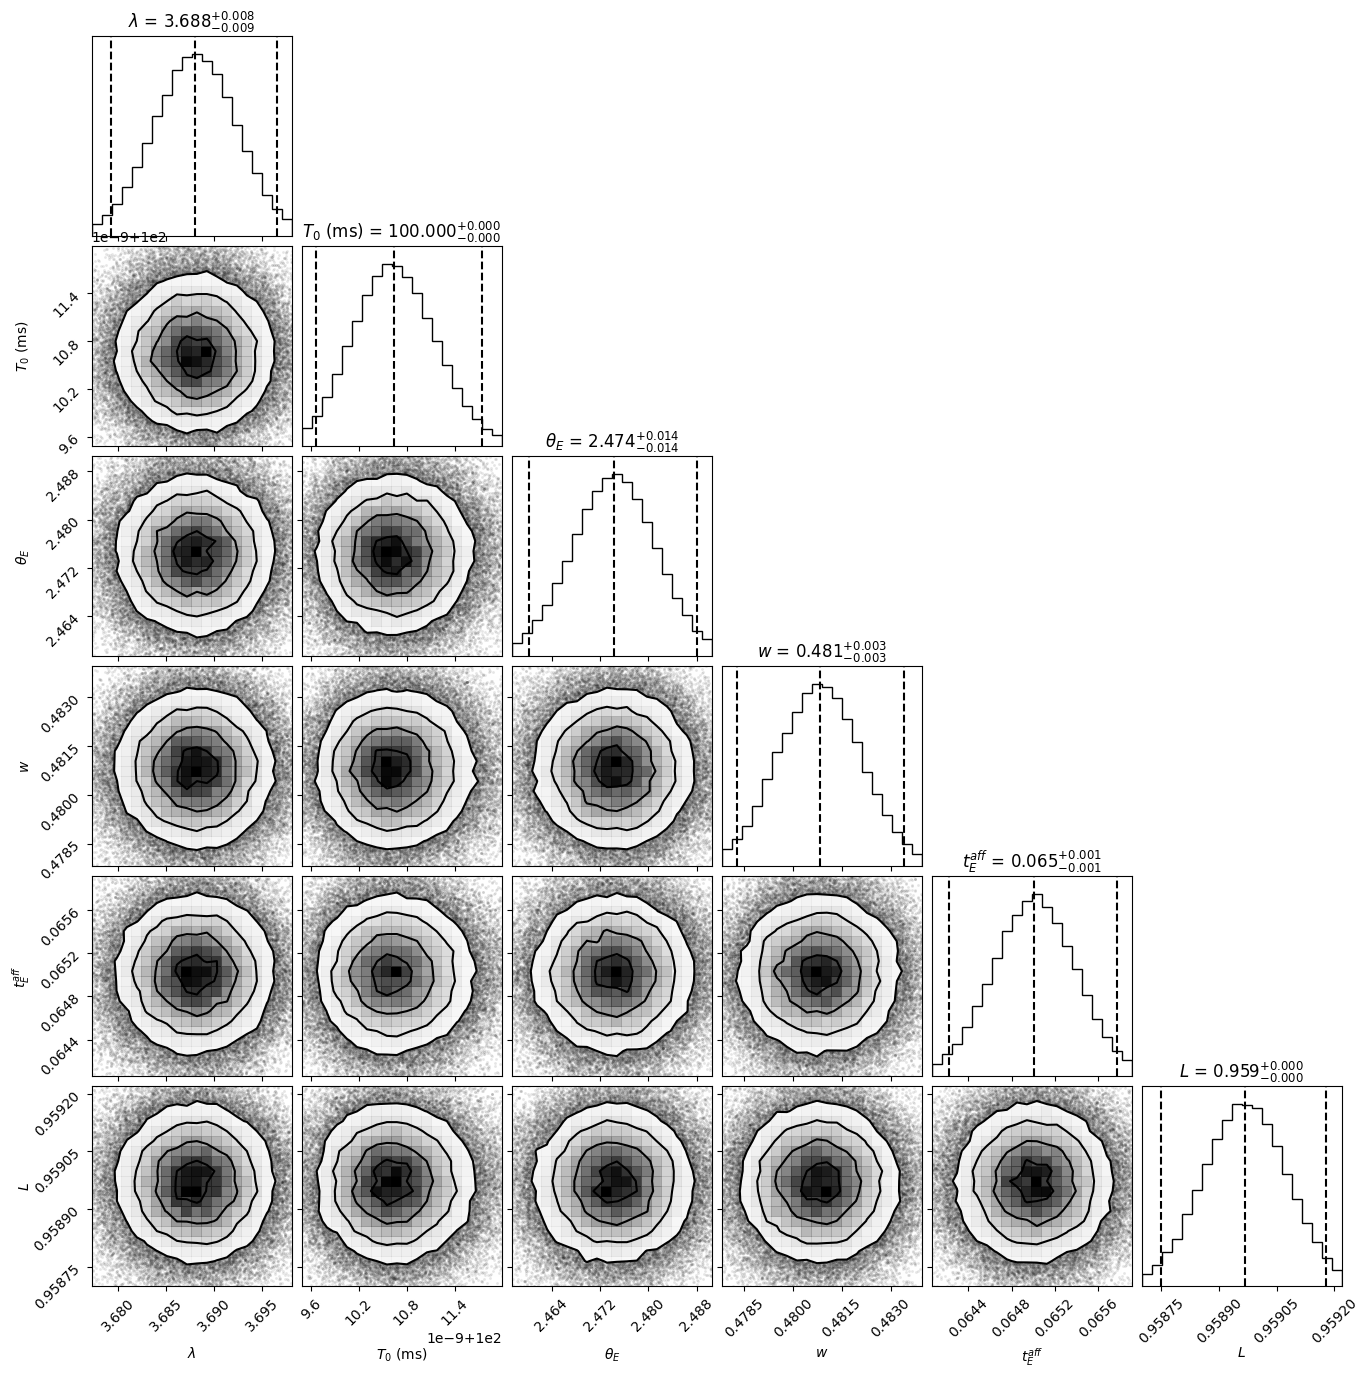

In [22]:
# Sample from the VBMC posterior (returns tuple: samples, log weights)
vp_samples = vp.sample(int(1e5))[0]

# Convert T_0 to ms
vp_samples[:, 1] *= 1e3  # T_0 is at index 1

# Parameter labels (order matters!)
param_labels = [r'$\lambda$', r'$T_0$ (ms)', r'$\theta_E$', r'$w$', r'$t_{E}^{aff}$', r'$L$']

# Compute 1st and 99th percentiles for each param to restrict range
percentiles = np.percentile(vp_samples, [1, 99], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in range(vp_samples.shape[1])]

# Create the corner plot
fig = corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".3f"
)

vp_samples[:, 1] /= 1e3  # T_0 is at index 1


plt.show()


In [ ]:
# vbmc.save('non_linear_only_norm_decent_non_convg.pkl')

# Simulation diagnostics

## params

In [24]:
rate_lambda = vp_samples[:, 0].mean()
T_0 = vp_samples[:, 1].mean()
theta_E = vp_samples[:, 2].mean()
w = vp_samples[:, 3].mean()
Z_E = (w - 0.5) * 2 * theta_E
t_E_aff = vp_samples[:, 4].mean()
rate_norm_l = vp_samples[:, 5].mean()

# Print them out
print("Posterior Means:")
print(f"rate_lambda  = {rate_lambda:.5f}")
print(f"T_0 (ms)      = {1e3*T_0:.5f}")
print(f"theta_E       = {theta_E:.5f}")
print(f"Z_E           = {Z_E:.5f}")
print(f"t_E_aff       = {1e3*t_E_aff:.5f} ms")
print(f"rate_norm_l   = {rate_norm_l:.5f}")


Posterior Means:
rate_lambda  = 3.68454
T_0 (ms)      = 100.00627
theta_E       = 2.47359
Z_E           = -0.09435
t_E_aff       = 64.99797 ms
rate_norm_l   = 0.95895


# TEMP CHANGE OF PARAMS TO TEST

In [32]:
w = 0.5
Z_E = 0

## simulate

In [33]:
# sample t-stim
N_sim = int(1e6)

t_stim_samples = df_led_off['intended_fix'].sample(N_sim, replace=True).values
ABL_samples = df_led_off['ABL'].sample(N_sim, replace=True).values
ILD_samples = df_led_off['ILD'].sample(N_sim, replace=True).values

N_print = int(N_sim / 5)
dt  = 1e-4

sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples[iter_num], rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

os id: 1519831, In iter_num: 0, ABL: 20, ILD: -1.0, t_stim: 0.259650432471508
os id: 1519839, In iter_num: 200000, ABL: 20, ILD: 1.0, t_stim: 1.03954015407128
os id: 1519848, In iter_num: 400000, ABL: 40, ILD: -1.0, t_stim: 0.236962228646287
os id: 1519855, In iter_num: 600000, ABL: 40, ILD: -16.0, t_stim: 0.221193492666056
os id: 1519838, In iter_num: 800000, ABL: 20, ILD: -2.0, t_stim: 0.247365599323767


## prepare valid sim df, data df

In [34]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df_valid = sim_results_df[
    (sim_results_df['rt'] > sim_results_df['t_stim']) &
    (sim_results_df['rt'] - sim_results_df['t_stim'] < 1)
].copy()
sim_results_df_valid.loc[:, 'correct'] = (sim_results_df_valid['ILD'] * sim_results_df_valid['choice']).apply(lambda x: 1 if x > 0 else 0)


df_led_off_valid_renamed = df_led_off_valid.rename(columns = {
    'timed_fix': 'rt',
    'intended_fix': 't_stim'
}).copy()

sim_df_1 = sim_results_df_valid.copy()
data_df_1 = df_led_off_valid_renamed.copy()

## plots

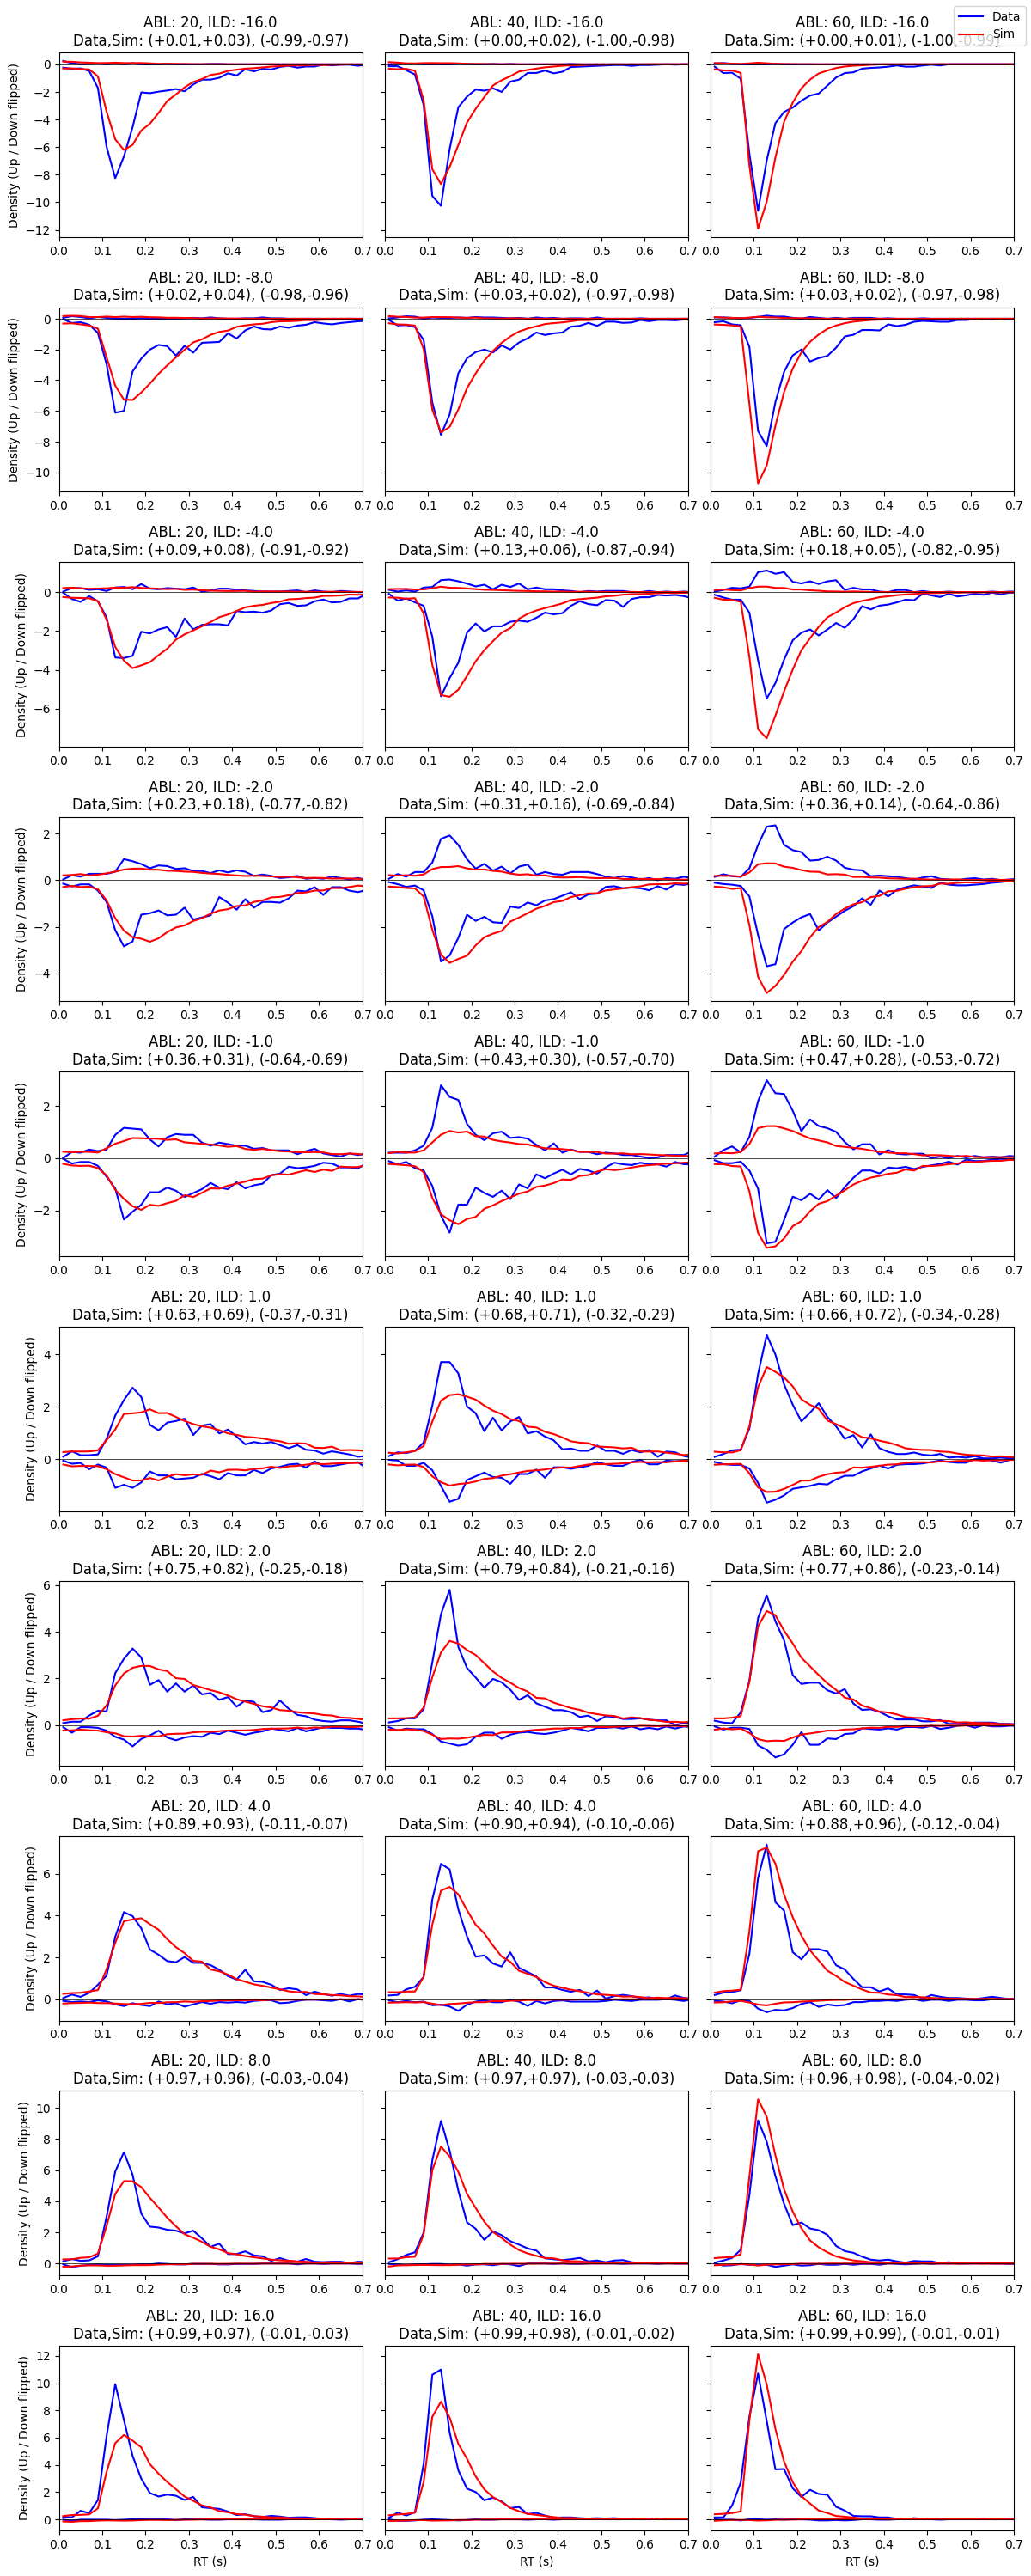

In [35]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + (0.5 * bw)

n_rows = len(ILD_arr)
n_cols = len(ABL_arr)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

for i_idx, ILD in enumerate(ILD_arr):
    for a_idx, ABL in enumerate(ABL_arr):
        ax = axs[i_idx, a_idx] if n_rows > 1 else axs[a_idx]

        sim_df_1_ABL_ILD = sim_df_1[(sim_df_1['ABL'] == ABL) & (sim_df_1['ILD'] == ILD)]
        data_df_1_ABL_ILD = data_df_1[(data_df_1['ABL'] == ABL) & (data_df_1['ILD'] == ILD)]

        sim_up = sim_df_1_ABL_ILD[sim_df_1_ABL_ILD['choice'] == 1]
        sim_down = sim_df_1_ABL_ILD[sim_df_1_ABL_ILD['choice'] == -1]
        data_up = data_df_1_ABL_ILD[data_df_1_ABL_ILD['choice'] == 1]
        data_down = data_df_1_ABL_ILD[data_df_1_ABL_ILD['choice'] == -1]

        sim_up_rt = sim_up['rt'] - sim_up['t_stim']
        sim_down_rt = sim_down['rt'] - sim_down['t_stim']
        data_up_rt = data_up['rt'] - data_up['t_stim']
        data_down_rt = data_down['rt'] - data_down['t_stim']

        sim_up_hist, _ = np.histogram(sim_up_rt, bins=bins, density=True)
        sim_down_hist, _ = np.histogram(sim_down_rt, bins=bins, density=True)
        data_up_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)
        data_down_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

        # Normalize histograms by proportion of trials
        sim_up_hist *= len(sim_up) / len(sim_df_1_ABL_ILD)
        sim_down_hist *= len(sim_down) / len(sim_df_1_ABL_ILD)
        data_up_hist *= len(data_up) / len(data_df_1_ABL_ILD)
        data_down_hist *= len(data_down) / len(data_df_1_ABL_ILD)

        # Plot
        ax.plot(bin_centers, data_up_hist, color='b', label='Data' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(bin_centers, -data_down_hist, color='b')
        ax.plot(bin_centers, sim_up_hist, color='r', label='Sim' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(bin_centers, -sim_down_hist, color='r')

        # Compute fractions
        data_total = len(data_df_1_ABL_ILD)
        sim_total = len(sim_df_1_ABL_ILD)
        data_up_frac = len(data_up) / data_total if data_total else 0
        data_down_frac = len(data_down) / data_total if data_total else 0
        sim_up_frac = len(sim_up) / sim_total if sim_total else 0
        sim_down_frac = len(sim_down) / sim_total if sim_total else 0

        ax.set_title(
            f"ABL: {ABL}, ILD: {ILD}\n"
            f"Data,Sim: (+{data_up_frac:.2f},+{sim_up_frac:.2f}), "
            f"(-{data_down_frac:.2f},-{sim_down_frac:.2f})"
        )
        
        ax.axhline(0, color='k', linewidth=0.5)
        ax.set_xlim([0, 0.7])
        if a_idx == 0:
            ax.set_ylabel("Density (Up / Down flipped)")
        if i_idx == n_rows - 1:
            ax.set_xlabel("RT (s)")

fig.tight_layout()
fig.legend(loc='upper right')
plt.show()


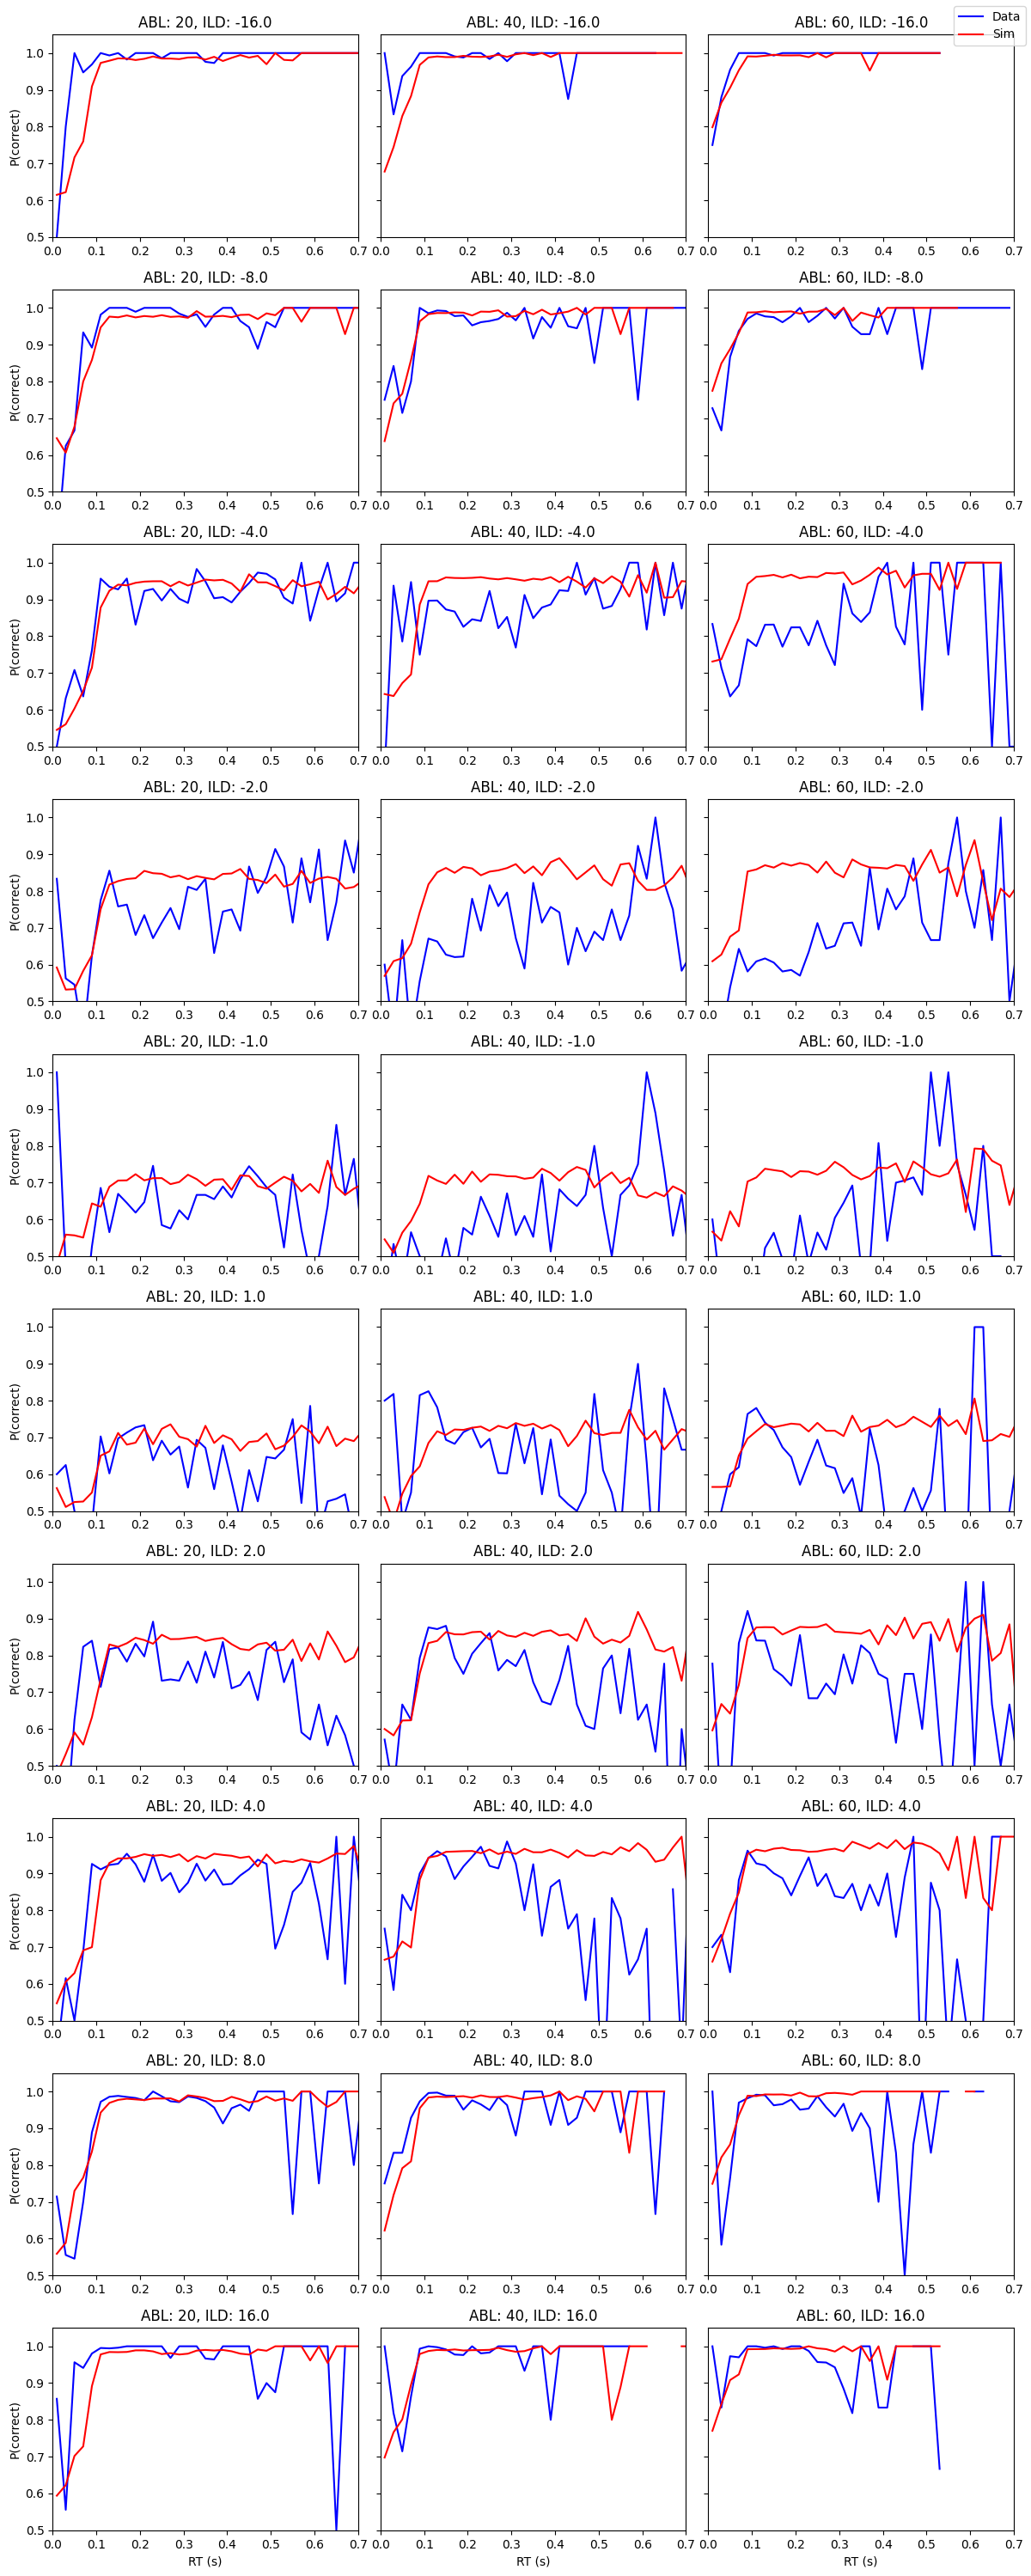

In [36]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + (0.5 * bw)

def plot_tacho(df_1):
    df_1 = df_1.copy()
    df_1['RT_bin'] = pd.cut(df_1['rt'] - df_1['t_stim'], bins=bins, include_lowest=True)
    grouped = df_1.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
    grouped['bin_mid'] = grouped.index.map(lambda x: x.mid)
    return grouped['bin_mid'], grouped['mean']

n_rows = len(ILD_arr)
n_cols = len(ABL_arr)

# === Define fig2 ===
fig2, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

for i_idx, ILD in enumerate(ILD_arr):
    for a_idx, ABL in enumerate(ABL_arr):
        ax = axs[i_idx, a_idx] if n_rows > 1 else axs[a_idx]

        sim_df_1_ABL_ILD = sim_df_1[(sim_df_1['ABL'] == ABL) & (sim_df_1['ILD'] == ILD)]
        data_df_1_ABL_ILD = data_df_1[(data_df_1['ABL'] == ABL) & (data_df_1['ILD'] == ILD)]

        sim_tacho_x, sim_tacho_y = plot_tacho(sim_df_1_ABL_ILD)
        data_tacho_x, data_tacho_y = plot_tacho(data_df_1_ABL_ILD)

        # Plotting
        ax.plot(data_tacho_x, data_tacho_y, color='b', label='Data' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(sim_tacho_x, sim_tacho_y, color='r', label='Sim' if (i_idx == 0 and a_idx == 0) else "")

        ax.set_ylim([0.5, 1.05])
        ax.set_xlim([0, 0.7])
        ax.set_title(f"ABL: {ABL}, ILD: {ILD}")
        if a_idx == 0:
            ax.set_ylabel("P(correct)")
        if i_idx == n_rows - 1:
            ax.set_xlabel("RT (s)")

fig2.tight_layout()
fig2.legend(loc='upper right')
plt.show()


# Grand RTDs and tacho

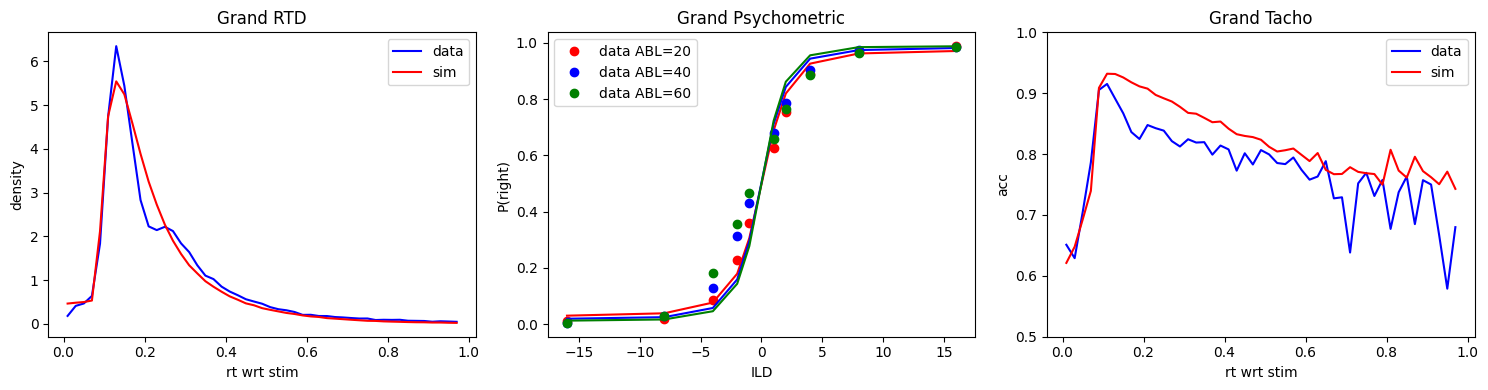

In [37]:
def grand_rtd(df_1):
    df_1_rt = df_1['rt'] - df_1['t_stim']
    rt_hist, _ = np.histogram(df_1_rt, bins=bins, density=True)
    return rt_hist

def plot_psycho(df_1):
    prob_choice_dict = {}

    all_ABL = np.sort(df_1['ABL'].unique())
    all_ILD = np.sort(df_1['ILD'].unique())

    for abl in all_ABL:
        filtered_df = df_1[df_1['ABL'] == abl]
        prob_choice_dict[abl] = [
            sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild])
            for ild in all_ILD
        ]

    return prob_choice_dict

# === Define fig3 ===
fig3, axes = plt.subplots(1, 3, figsize=(15, 4))

# === Grand RTD ===
axes[0].plot(bin_centers, grand_rtd(data_df_1), color='b', label='data')
axes[0].plot(bin_centers, grand_rtd(sim_df_1), color='r', label='sim')
axes[0].legend()
axes[0].set_xlabel('rt wrt stim')
axes[0].set_ylabel('density')
axes[0].set_title('Grand RTD')

# === Grand Psychometric ===
data_psycho = plot_psycho(data_df_1)
sim_psycho = plot_psycho(sim_df_1)

colors = ['r', 'b', 'g']  # Adjust colors for your ABLs
for i, ABL in enumerate(ABL_arr):
    axes[1].plot(ILD_arr, data_psycho[ABL], color=colors[i], label=f'data ABL={ABL}', marker='o', linestyle='None')
    axes[1].plot(ILD_arr, sim_psycho[ABL], color=colors[i], linestyle='-')

axes[1].legend()
axes[1].set_xlabel('ILD')
axes[1].set_ylabel('P(right)')
axes[1].set_title('Grand Psychometric')

# === Grand Tacho ===
data_tacho_x, data_tacho_y = plot_tacho(data_df_1)
sim_tacho_x, sim_tacho_y = plot_tacho(sim_df_1)

axes[2].plot(data_tacho_x, data_tacho_y, color='b', label='data')
axes[2].plot(sim_tacho_x, sim_tacho_y, color='r', label='sim')
axes[2].legend()
axes[2].set_xlabel('rt wrt stim')
axes[2].set_ylabel('acc')
axes[2].set_title('Grand Tacho')
axes[2].set_ylim(0.5, 1)

fig3.tight_layout()
plt.show()


# all in a single PDF?

In [38]:
import os
from matplotlib.backends.backend_pdf import PdfPages
from docx import Document
from docx.shared import Inches

# Set your filename prefix
output_filename = 'unbiased_with_w_V3_NON_LINEAR_ONLY_Norm_report'

# Ensure output directory
os.makedirs('outputs', exist_ok=True)

# === Save individual figures as PNGs ===
fig1_path = f'outputs/{output_filename}_updown_hist.png'
fig2_path = f'outputs/{output_filename}_tacho.png'
fig3_path = f'outputs/{output_filename}_grand_summary.png'

fig.savefig(fig1_path)
fig2.savefig(fig2_path)
fig3.savefig(fig3_path)

# === Create PDF with all three figures ===
pdf_path = f'outputs/{output_filename}.pdf'
with PdfPages(pdf_path) as pdf:
    for fig_item in [fig, fig2, fig3]:
        pdf.savefig(fig_item)

# === Create DOCX with all three figures ===
doc = Document()
doc.add_heading('RTD and Tacho Analysis Results', 0)

for img_path in [fig1_path, fig2_path, fig3_path]:
    doc.add_page_break()
    doc.add_picture(img_path, width=Inches(6.5))

docx_path = f'outputs/{output_filename}.docx'
doc.save(docx_path)

print(f"✅ Saved PDF to: {pdf_path}")
print(f"✅ Saved DOCX to: {docx_path}")


✅ Saved PDF to: outputs/unbiased_with_w_V3_NON_LINEAR_ONLY_Norm_report.pdf
✅ Saved DOCX to: outputs/unbiased_with_w_V3_NON_LINEAR_ONLY_Norm_report.docx


# up and down RTD

In [ ]:
N_theory = int(1e3)
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(-1, 2, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A, theta_A)
    P_A_samples[idx, :] = pdf

P_A_samples_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [ ]:
# Create figure and axes row by row to enable row-wise shared Y axes
fig = plt.figure(figsize=(18, 24))
axes = []

for i in range(10):  # 10 rows
    row_axes = []
    for j in range(3):  # 3 columns
        ax = fig.add_subplot(10, 3, i * 3 + j + 1, sharey=row_axes[0] if row_axes else None)
        row_axes.append(ax)
    axes.append(row_axes)

fig.subplots_adjust(hspace=0.8, wspace=0.4)

bin_size = 0.02
bins = np.arange(-1, 2, bin_size)
bin_centers = bins[:-1] + (bin_size / 2)
t_pts = np.arange(-1, 2, 0.001)

phi_params_obj = np.nan

for a_idx, ABL in enumerate(ABL_arr):
    for i_idx, ILD in enumerate(ILD_arr):
        ax = axes[i_idx][a_idx]  # axes[row][col] = (ILD, ABL)

        # data
        df_led_off_abort_and_valid = df_led_off[(df_led_off['abort_event'] == 3) | (df_led_off['response_poke'].isin([2,3]))]
        mask_invalid = ~df_led_off_abort_and_valid['response_poke'].isin([2, 3])
        # Step 2: Assign random values (2 or 3 with 50% chance) to those rows
        df_led_off_abort_and_valid.loc[mask_invalid, 'response_poke'] = np.random.choice([2, 3], size=mask_invalid.sum())

        df_ABL_ILD = df_led_off_abort_and_valid[
            (df_led_off_abort_and_valid['ABL'] == ABL) & (df_led_off_abort_and_valid['ILD'] == ILD)]
        # df_ABL_ILD = df_led_off_valid[
        #     (df_led_off_valid['ABL'] == ABL) & (df_led_off_valid['ILD'] == ILD)]
        df_ABL_ILD_up = df_ABL_ILD[df_ABL_ILD['response_poke'] == 3]
        df_ABL_ILD_down = df_ABL_ILD[df_ABL_ILD['response_poke'] == 2]

        df_ABL_ILD_up_rt = df_ABL_ILD_up['timed_fix'] - df_ABL_ILD_up['intended_fix']
        df_ABL_ILD_down_rt = df_ABL_ILD_down['timed_fix'] - df_ABL_ILD_down['intended_fix']

        data_up_rt_hist, _ = np.histogram(df_ABL_ILD_up_rt, bins=bins, density=True)
        data_down_rt_hist, _ = np.histogram(df_ABL_ILD_down_rt, bins=bins, density=True)

        data_frac_up = len(df_ABL_ILD_up) / len(df_ABL_ILD)
        data_frac_down = len(df_ABL_ILD_down) / len(df_ABL_ILD)

        # theory
        theory_ABL_ILD_up = np.zeros_like(t_pts)
        theory_ABL_ILD_down = np.zeros_like(t_pts)

        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            theory_ABL_ILD_up[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, 1,
                P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l,
                is_norm, is_time_vary, K_max)

            theory_ABL_ILD_down[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, -1,
                P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l,
                is_norm, is_time_vary, K_max)

        ax.plot(bin_centers, data_up_rt_hist * data_frac_up, 'b--', label='Data Up' if i_idx == 0 and a_idx == 0 else "")
        ax.plot(bin_centers, -data_down_rt_hist * data_frac_down, 'b--', label='Data Down' if i_idx == 0 and a_idx == 0 else "")
        ax.plot(t_pts, theory_ABL_ILD_up, 'r-', label='Theory Up' if i_idx == 0 and a_idx == 0 else "")
        ax.plot(t_pts, -theory_ABL_ILD_down, 'r-', label='Theory Down' if i_idx == 0 and a_idx == 0 else "")

        ax.set_title(f'ABL={ABL}, ILD={ILD}', fontsize=9)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_xlim(-0.2, 0.7)

# Add single legend outside the plot
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.98, 1])
plt.show()


# tachometric

In [ ]:
import matplotlib.pyplot as plt

# Prepare the figure and axes
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(18, 24), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
bin_size = 0.02
bins = np.arange(-1, 2, bin_size)
bin_centers = bins[:-1] + (bin_size / 2)
t_pts = np.arange(-1, 2, 0.001)

phi_params_obj = np.nan

for a_idx, ABL in enumerate(ABL_arr):
    for i_idx, ILD in enumerate(ILD_arr):
        ax = axes[i_idx, a_idx]  # (row=ILD, col=ABL)

        # data
        df_led_off_abort_and_valid = df_led_off[(df_led_off['abort_event'] == 3) | (df_led_off['response_poke'].isin([2,3]))]
        mask_invalid = ~df_led_off_abort_and_valid['response_poke'].isin([2, 3])
        df_led_off_abort_and_valid.loc[mask_invalid, 'response_poke'] = np.random.choice([2, 3], size=mask_invalid.sum())

        df_ABL_ILD = df_led_off_abort_and_valid[
            (df_led_off_abort_and_valid['ABL'] == ABL) & (df_led_off_abort_and_valid['ILD'] == ILD)].copy()
        # df_ABL_ILD = df_led_off_valid[
        #     (df_led_off_valid['ABL'] == ABL) & (df_led_off_valid['ILD'] == ILD)].copy()
        
        df_ABL_ILD.loc[:, 'RT'] = df_ABL_ILD['timed_fix'] - df_ABL_ILD['intended_fix']
        df_ABL_ILD.loc[:, 'is_correct'] = (
                    df_ABL_ILD['ILD'] * (2 * df_ABL_ILD['response_poke'] - 5)
                ) > 0
        df_ABL_ILD.loc[:, 'rt_bin'] = pd.cut(
                df_ABL_ILD['RT'], bins=bins, include_lowest=True
            )
        tachometric_curve = df_ABL_ILD.groupby('rt_bin', observed=False)['is_correct'].mean()


        # theory
        theory_ABL_ILD_up = np.zeros_like(t_pts)
        theory_ABL_ILD_down = np.zeros_like(t_pts)
        theory_tacho = np.zeros_like(t_pts)
        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            theory_ABL_ILD_up[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, 1,
                P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l,
                is_norm, is_time_vary, K_max)

            theory_ABL_ILD_down[idx] = up_or_down_RTs_fit_wrt_stim_fn(
                t, -1,
                P_A, C_A,
                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l,
                is_norm, is_time_vary, K_max)

            if ILD > 0:
                theory_tacho[idx] = theory_ABL_ILD_up[idx] / (theory_ABL_ILD_up[idx] + theory_ABL_ILD_down[idx] + 1e-10)
            else:
                theory_tacho[idx] = theory_ABL_ILD_down[idx] / (theory_ABL_ILD_up[idx] + theory_ABL_ILD_down[idx] + 1e-10)
        

        ax.plot(bin_centers, tachometric_curve, 'b--')
        ax.plot(t_pts, theory_tacho, 'r-')
        ax.set_title(f'ABL={ABL}, ILD={ILD}', fontsize=9)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_xlim(0, 0.7)
        ax.set_ylim(0.5, 1.05)

# Add shared axis labels

# Add a single legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.98, 1])  # leave space for legend
plt.show()


# grand rtd, psycho, tacho

In [ ]:
# sample t-stim
N_sim = int(1e6)

t_stim_samples = df['intended_fix'].sample(N_sim, replace=True).values
ABL_samples = df['ABL'].sample(N_sim, replace=True).values
ILD_samples = df['ILD'].sample(N_sim, replace=True).values

N_print = int(N_sim / 5)
dt  = 1e-4

In [ ]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples[iter_num], rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

In [ ]:
# sim df
sim_results_df = pd.DataFrame(sim_results)
sim_results_df_valid = sim_results_df[sim_results_df['rt'] > sim_results_df['t_stim']]
sim_results_df_valid_less_than_1 = sim_results_df_valid[sim_results_df_valid['rt'] - sim_results_df_valid['t_stim'] < 1].copy()

# rename data df cols
df_led_off_valid.loc[:,'choice'] = 2*df_led_off_valid['response_poke'] - 5
df_led_off_valid_renamed = df_led_off_valid.rename(columns={
    'timed_fix': 'rt',
    'intended_fix': 't_stim'
}).copy()

# add corr cols in both
df_led_off_valid_renamed.loc[:,'correct'] = (df_led_off_valid_renamed['choice'] * df_led_off_valid_renamed['ILD'] > 0).astype(int)
sim_results_df_valid_less_than_1.loc[:,'correct'] = (sim_results_df_valid_less_than_1['choice'] * sim_results_df_valid_less_than_1['ILD'] > 0).astype(int)

In [ ]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + 0.5*bw
def grand_rtd(df_1):
    df_1_rt = df_1['rt'] - df_1['t_stim']
    rt_hist, _ = np.histogram(df_1_rt, bins=bins, density=True)
    return rt_hist

def plot_psycho(df_1):
    prob_choice_dict = {}

    all_ABL = np.sort(df_1['ABL'].unique())
    all_ILD = np.sort(df_1['ILD'].unique())

    for abl in all_ABL:
        filtered_df = df_1[df_1['ABL'] == abl]
        prob_choice_dict[abl] = [sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild]) for ild in all_ILD]

    return prob_choice_dict

def plot_tacho(df_1):
    # prob of correct vs RT
    df_1.loc[:, 'RT_bin'] = pd.cut(df_1['rt'] - df_1['t_stim'], bins=bins, include_lowest=True)
    grouped_by_rt_bin = df_1.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
    grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
    return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# === grand RTD ===
axes[0].plot(bin_centers, grand_rtd(df_led_off_valid_renamed), color='b', label='data')
axes[0].plot(bin_centers, grand_rtd(sim_results_df_valid_less_than_1), color='r', label='sim')
axes[0].legend()
axes[0].set_xlabel('rt wrt stim')
axes[0].set_ylabel('density')
axes[0].set_title('Grand RTD')

# === grand psycho ===
data_psycho = plot_psycho(df_led_off_valid_renamed)
sim_psycho = plot_psycho(sim_results_df_valid_less_than_1)

colors = ['r', 'b', 'g']  # Define colors for each ABL
for i, ABL in enumerate(ABL_arr):
    axes[1].plot(ILD_arr, data_psycho[ABL], color=colors[i], label=f'data ABL={ABL}', marker='o', linestyle='None')
    axes[1].plot(ILD_arr, sim_psycho[ABL], color=colors[i], label=f'sim ABL={ABL}', linestyle='-')

axes[1].legend()
axes[1].set_xlabel('ILD')
axes[1].set_ylabel('P(right)')
axes[1].set_title('Grand Psychometric')

# === grand tacho ===
data_tacho_x, data_tacho_y = plot_tacho(df_led_off_valid_renamed)
sim_tacho_x, sim_tacho_y = plot_tacho(sim_results_df_valid_less_than_1)

axes[2].plot(data_tacho_x, data_tacho_y, color='b', label='data')
axes[2].plot(sim_tacho_x, sim_tacho_y, color='r', label='sim')
axes[2].legend()
axes[2].set_xlabel('rt wrt stim')
axes[2].set_ylabel('acc')
axes[2].set_title('Grand Tacho')
axes[2].set_ylim(0.5, 1);
